# imports

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as mn
from sklearn.metrics import r2_score,mean_squared_error
import plotly

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as mn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error

import keras
from keras import Sequential
from keras.layers import SimpleRNN
from keras import models
from keras import layers

from copy import copy

Using TensorFlow backend.


In [0]:
!ls drive/My\ Drive

'Colab Notebooks'	     MatlabResults
 Figures		     Models
 HH_ag.csv		     para_comb_20p_sample.csv
 HH_paramter_space_40s.csv   PR_ag.csv
 HH_voltage_40s.csv	     voltages_AP_30sek_sample.csv


In [0]:
%%time
HHss_df = pd.read_csv("drive/My Drive/HH_paramter_space_40s.csv",index_col=0)
names = ['gbar_Na','gbar_L','E_L','Cm','gbar_K','E_Na','E_K']
HHss_df.columns = names
names = HHss_df.columns

CPU times: user 21.2 ms, sys: 7.7 ms, total: 28.9 ms
Wall time: 42.1 ms


In [0]:
HHag_df = pd.read_csv("drive/My Drive/HH_ag.csv",index_col=0)

In [0]:
HHag_df.head()

,n_ap,first_ap_time,first_ap_amp,first_ap_width
0,5,26,42.682561,63.846107
1,1,27,52.059134,54.095856
2,1,22,42.537257,59.980696
3,1,23,56.381921,53.296342
4,2,26,37.084930,61.620318


In [0]:
HHn_ap_df = HHag_df['n_ap']


In [0]:
HHag_df = HHag_df[['first_ap_time','first_ap_amp','first_ap_width']]
print(HHag_df.shape)

(2187, 3)


In [0]:
ag_indexes = ~pd.isna(HHag_df).any(axis=1)

In [0]:
HHss_ag_df = HHss_df[ag_indexes]
HHag_df = HHag_df[ag_indexes]
print(HHss_ag_df.shape)
print(HHag_df.shape)

(2187, 7)
(2187, 3)


In [0]:
HHss_ag = HHss_ag_df.values
HHag = HHag_df.values

# Standardize and scale

In [0]:
X_Train, X_test, y_Train, y_test = train_test_split(HHss_ag,HHag,test_size=0.3,random_state=111)

In [0]:
scx = StandardScaler()
scy = StandardScaler()


X_Train = scx.fit_transform(X_Train)
y_Train = scy.fit_transform(y_Train)

X_test = scx.transform(X_test)
y_test = scy.transform(y_test)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_Train,y_Train,test_size=0.2,random_state=1234)

## Models train

In [0]:
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
  
  

In [0]:

model1 = models.Sequential()
model1.add(layers.Dense(9, activation='relu', input_shape=(X_train.shape[1],)))
model1.add(layers.Dense(y_train.shape[1]))
model1.compile(optimizer='adam', loss='mse', metrics=[r_square])

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
#plot_model(model1, to_file="drive/My Drive/Figures/models/HH_ag_arch.png", show_shapes=True, show_layer_names=True)

In [0]:
%%time
history1 = model1.fit(X_Train, y_Train,
                  epochs=2000,
                  batch_size=256,
                  verbose=0,
                  validation_data=(X_val, y_val))

Train on 1530 samples, validate on 306 samples
Epoch 1/2000
1530/1530 [==============================] - 0s 299us/step - loss: 1.7025 - r_square: -0.7074 - val_loss: 1.6211 - val_r_square: -0.5972
Epoch 2/2000
1530/1530 [==============================] - 0s 27us/step - loss: 1.5639 - r_square: -0.5663 - val_loss: 1.4950 - val_r_square: -0.4726
Epoch 3/2000
1530/1530 [==============================] - 0s 28us/step - loss: 1.4433 - r_square: -0.4454 - val_loss: 1.3853 - val_r_square: -0.3642
Epoch 4/2000
1530/1530 [==============================] - 0s 29us/step - loss: 1.3351 - r_square: -0.3404 - val_loss: 1.2913 - val_r_square: -0.2714
Epoch 5/2000
1530/1530 [==============================] - 0s 30us/step - loss: 1.2462 - r_square: -0.2470 - val_loss: 1.2098 - val_r_square: -0.1909
Epoch 6/2000
1530/1530 [==============================] - 0s 34us/step - loss: 1.1671 - r_square: -0.1674 - val_loss: 1.1397 - val_r_square: -0.1218
Epoch 7/2000
1530/1530 [==============================] - 

KeyboardInterrupt: ignored

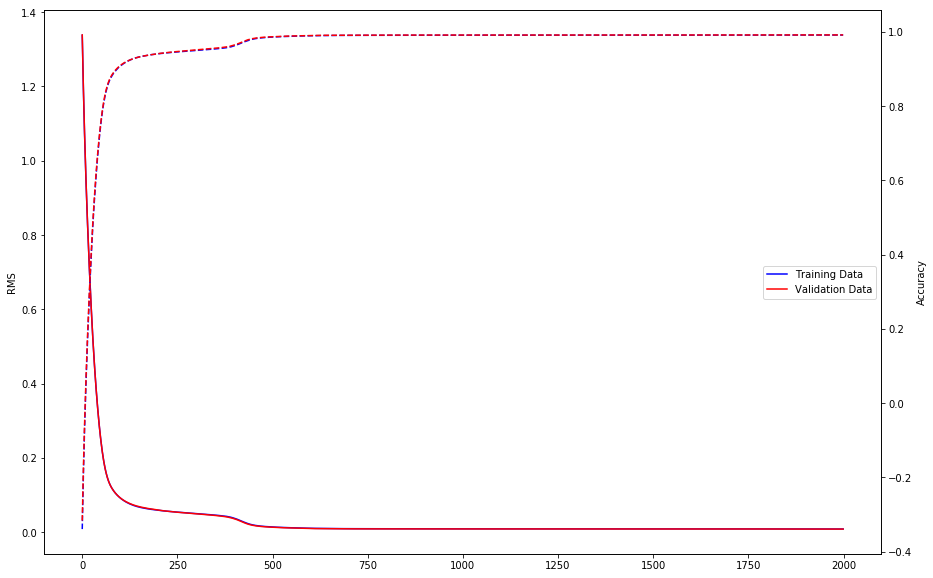

In [0]:
plt.figure(figsize=(15,10))
ax = plt.gca()
ax.plot(history1.history['loss'],label='Training Data',c='blue')
ax.plot(history1.history['val_loss'],label='Validation Data',c='red')
plt.ylabel('RMS')
plt.legend(loc='center right')

ax2 = ax.twinx()
ax2.plot(history1.history['r_square'],'--',c='blue')
ax2.plot(history1.history['val_r_square'],'--',c='red')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
#plt.savefig("drive/My Drive/Figures/R2plots/HHag_training")

In [0]:
results_df=pd.DataFrame()
ypred = model2.predict(X_test)

extra_results_df = pd.DataFrame([r2_score(y_test[:,i],ypred[:,i]) for i in range(3)],index=['first_ap_time','first_ap_amp','first_ap_width'],columns=['1500 epochs'])
results_df = pd.concat([results_df,extra_results_df],axis=1)
results_df

##  Model Testing

In [0]:
X_Train, X_test, y_Train, y_test = train_test_split(HHss_ag,HHag,test_size=0.3,random_state=111)
scx = StandardScaler()
scy = StandardScaler()


X_Train = scx.fit_transform(X_Train)
y_Train = scy.fit_transform(y_Train)

X_test = scx.transform(X_test)
y_test = scy.transform(y_test)

In [0]:
model2 = models.Sequential()
model2.add(layers.Dense(9, activation='relu', input_shape=(X_train.shape[1],)))
model2.add(layers.Dense(y_train.shape[1]))
model2.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [0]:
%%time
history2 = model2.fit(X_Train, y_Train,
                  epochs=1500,
                  batch_size=256,
                  verbose=0)

CPU times: user 36.3 s, sys: 2.44 s, total: 38.7 s
Wall time: 41.3 s


In [0]:
results_df=pd.DataFrame()
ypred = model2.predict(X_test)

extra_results_df = pd.DataFrame([r2_score(y_test[:,i],ypred[:,i]) for i in range(3)],index=['first_ap_time','first_ap_amp','first_ap_width'],columns=['1500 epochs'])
results_df = pd.concat([results_df,extra_results_df],axis=1)
results_df

,1500 epochs
first_ap_time,0.976530
first_ap_amp,0.999632
first_ap_width,0.997532


# Permuted feature importance

In [0]:
target = HHag_df.columns

In [0]:
from copy import copy

def Permuted_feature_impotance(_X,y,model,seeds=[234]):
  
  base_yhat = model.predict(_X)
  base_line = np.array(
      [mean_squared_error(y[:,c],base_yhat[:,c])
       for c in range(base_yhat.shape[1])])
  
  PFI = np.zeros((len(seeds),_X.shape[1],y.shape[1]))
  
  for i,seed in enumerate(seeds):
    
    np.random.RandomState(seed) # Sets the random state for numpy
    for j in range(X_test.shape[1]):
      
      X = copy(_X)
      X[:,j] = np.random.permutation(X[:,j])

      perm_yhat = model.predict(X)
      



      FI_perm = np.array([mean_squared_error(y[:,c],perm_yhat[:,c]) for c in range(perm_yhat.shape[1])])
      PFI[i,j,:] = FI_perm - base_line
  
  return PFI


In [0]:
%%time
seeds = [123*i for i in range(1,5)]
PFI = Permuted_feature_impotance(X_test,y_test,model1,seeds)

CPU times: user 773 ms, sys: 84.2 ms, total: 857 ms
Wall time: 1 s


In [0]:
m = np.mean(PFI,axis=0)


Text(0.5, 1.0, 'first_ap_time')

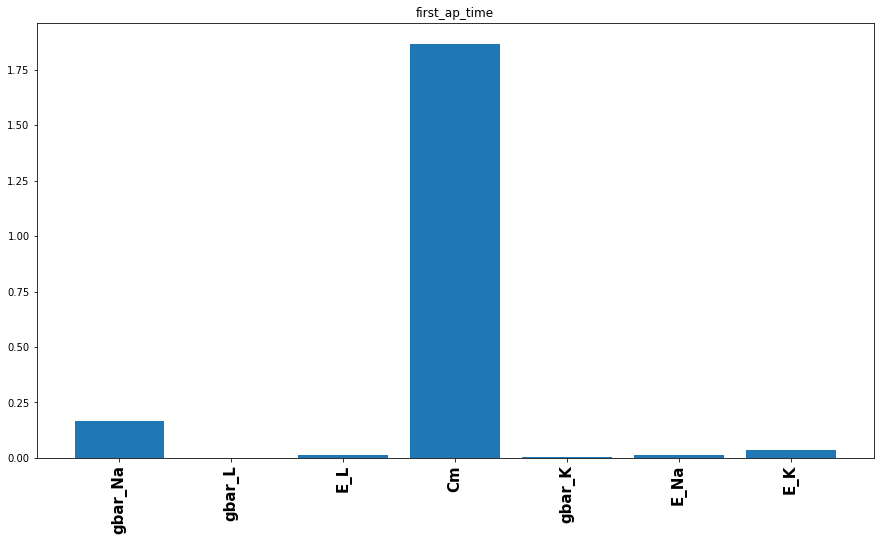

In [0]:
plt.figure(figsize=(15,8))
plt.bar(names,m[:,0])
plt.xticks(rotation='vertical');
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(15)
    tick.label1.set_fontweight('bold')
plt.title(target[0])

Text(0.5, 1.0, 'first_ap_amp')

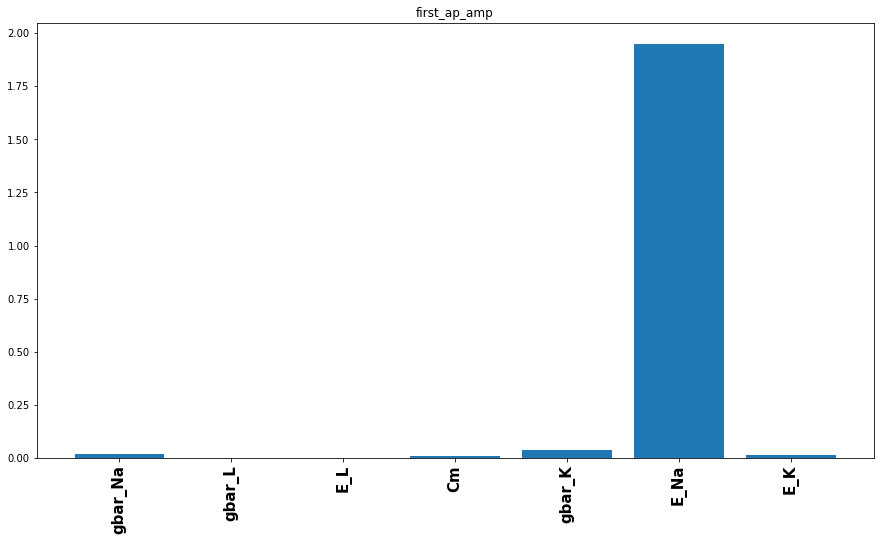

In [0]:
plt.figure(figsize=(15,8))
plt.bar(names,m[:,1])
plt.xticks(rotation='vertical');
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(15)
    tick.label1.set_fontweight('bold')
plt.title(target[1])

Text(0.5, 1.0, 'first_ap_width')

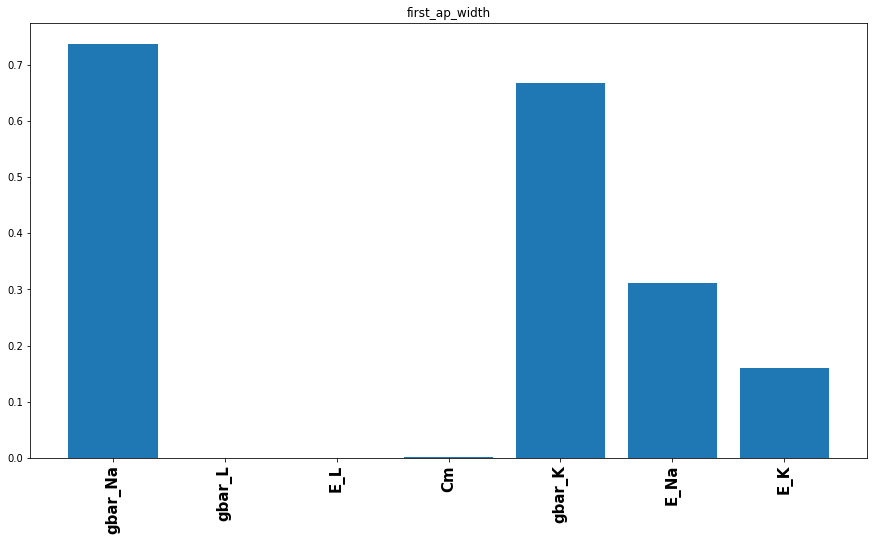

In [0]:
plt.figure(figsize=(15,8))
plt.bar(names,m[:,2])
plt.xticks(rotation='vertical');
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(15)
    tick.label1.set_fontweight('bold')
plt.title(target[2])

In [0]:
target

Index(['first_ap_time', 'first_ap_amp', 'first_ap_width'], dtype='object')

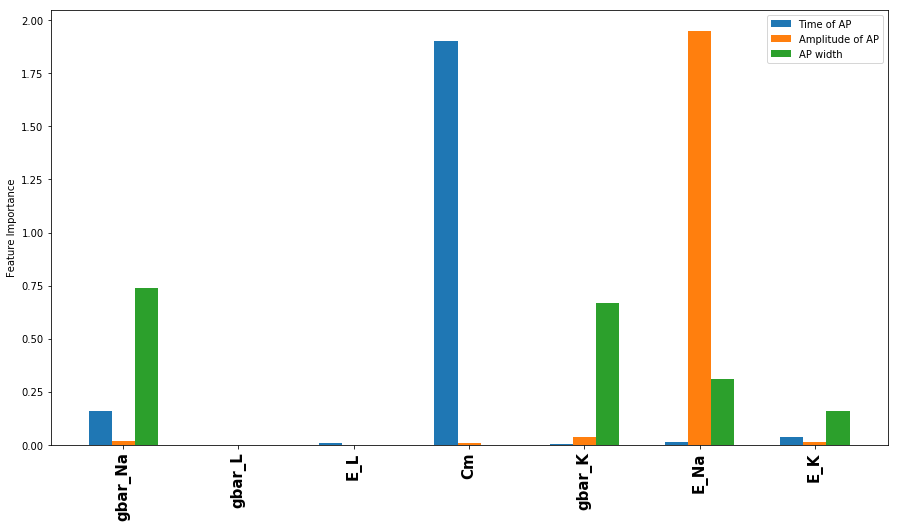

In [0]:
plt.figure(figsize=(15,8))
xa = np.array([i for i in range(len(names))])
plt.bar(xa-0.2,m[:,0],width=0.2)
plt.bar(xa,m[:,1],width=0.2)
plt.bar(xa+0.2,m[:,2],width=0.2)
plt.legend(['Time of AP','Amplitude of AP','AP width'])

plt.xticks(xa,names,fontsize=15,fontweight='bold')
plt.xticks(rotation='vertical');
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(15)
    tick.label1.set_fontweight('bold')
plt.ylabel('Feature Importance')
plt.savefig("drive/My Drive/Figures/R2plots/HHperm_ag")

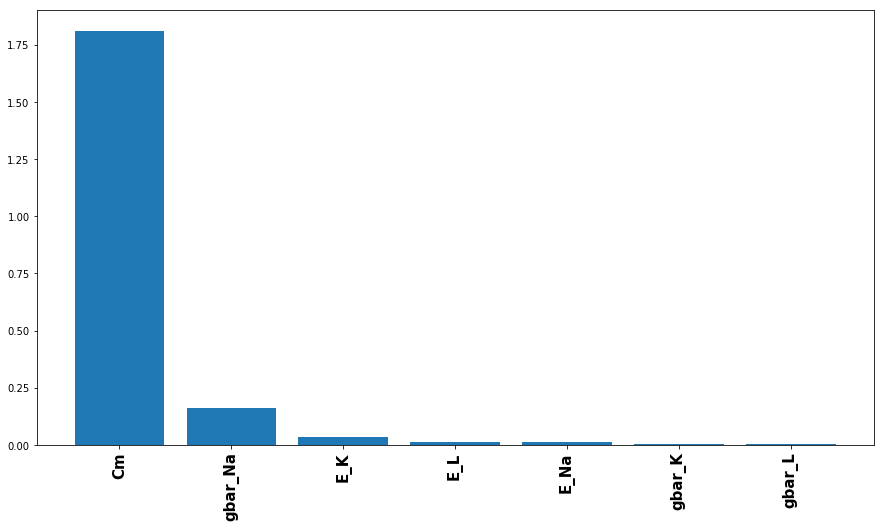

In [0]:
plt.figure(figsize=(15,8))
foonames = [n for _,n in sorted(zip(m[:,0],names))]
foom = sorted(m[:,0])
foonames.reverse()
foom.reverse()
plt.bar(foonames,foom)
plt.xticks(rotation='vertical');
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(15)
    tick.label1.set_fontweight('bold')
plt.savefig("drive/My Drive/Figures/R2plots/HHperm_firstap")

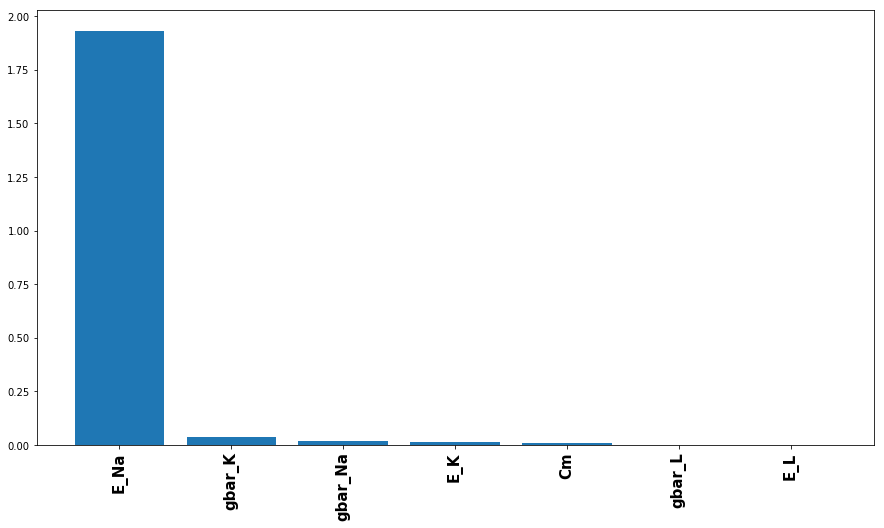

In [0]:
plt.figure(figsize=(15,8))
foonames = [n for _,n in sorted(zip(m[:,1],names))]
foom = sorted(m[:,1])
foonames.reverse()
foom.reverse()
plt.bar(foonames,foom)
plt.xticks(rotation='vertical');
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(15)
    tick.label1.set_fontweight('bold')
plt.savefig("drive/My Drive/Figures/R2plots/HHperm_firstapamp")

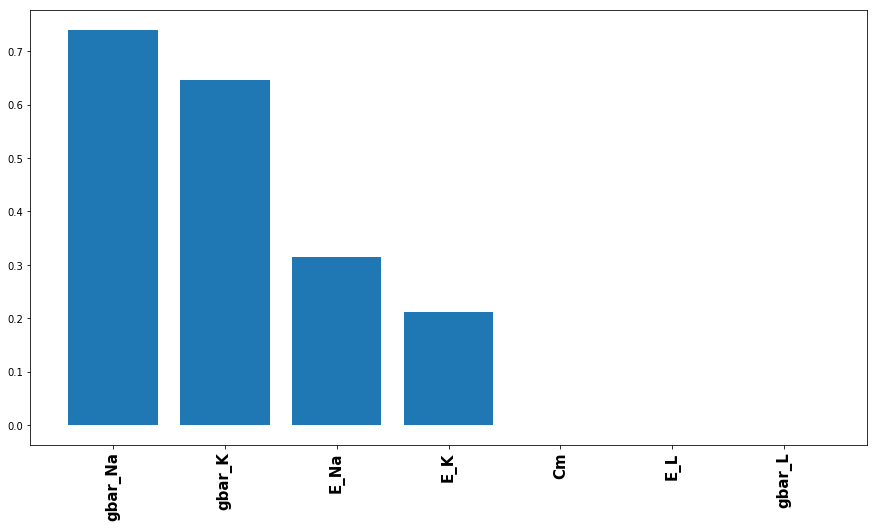

In [0]:
plt.figure(figsize=(15,8))
foonames = [n for _,n in sorted(zip(m[:,2],names))]
foom = sorted(m[:,2])
foonames.reverse()
foom.reverse()
plt.bar(foonames,foom)
plt.xticks(rotation='vertical');
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(15)
    tick.label1.set_fontweight('bold')
plt.savefig("drive/My Drive/Figures/R2plots/HHperm_firstapwidth")